In [1]:
import os, glob, torch, torchvision, cv2, PIL, time, random
from torchvision import transforms
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

from copy import deepcopy

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=True

In [3]:
device = "cuda" if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
# 5x: raw/flip/rotate/jitter/blur
# ResNet & VGG
CFG={'SEED' : 46,  # 42~46
     'IMG_SIZE' : 224,
     'AUGMENTATION' : 2,  # 1: ONLY flip / 2: 5가지 다
     'TEST_PORTION' : 0.5,  # Test set 비율
     'MODEL' : 3,  # 1: ResNet / 2: VGG / 3: Inception_v3
     'GLAND' : "PG",
     'CONTROL' : "NON_SJS",  # "NORMAL" or "NON_SJS"
     'EPOCHS' : 30,
     'BATCH_SIZE' : 64,
     'LR' : 1e-4}

In [5]:
seed_everything(CFG["SEED"])

In [6]:
control = CFG["CONTROL"]
seed = CFG["SEED"]
gland = CFG["GLAND"]

if CFG["AUGMENTATION"] == 1:
    augmentation = "2x"
else:
    augmentation = "5x"

if CFG["TEST_PORTION"] == 0.1:
    test_portion = "test10"
elif CFG["TEST_PORTION"] == 0.2:
    test_portion = "test20"
elif CFG["TEST_PORTION"] == 0.5:
    test_portion = "test50"

if CFG["MODEL"] == 1:
    model_name = "Res"
elif CFG["MODEL"] == 2:
    model_name = "VGG"
else:
    model_name = "Inception"

model_save_path = f"C:/Users/PC00/Desktop/HJ/Sjogren's Syndrome/{control}_save_path/{control}_{augmentation}_{test_portion}({gland}_{model_name})_seed{seed}.pt"

In [7]:
model_save_path  # model_save_path 제대로 호출했는지 확인하기

"C:/Users/PC00/Desktop/HJ/Sjogren's Syndrome/NON_SJS_save_path/NON_SJS_5x_test50(ALL_Inception)_seed46.pt"

In [8]:
# 파일 경로 가져오기
def GET_PATH(path, control_group):
    # Control group: "NORMAL" or "NON_SJS" (문자열 입력)
    # Gland: "PTG_" or "SMG_" (문자열 입력)
    control_list, sjs_list = [], []
    control_label, sjs_label = [], []
    for diagnosis in os.listdir(path):
        if diagnosis == control_group:    # CONTROL: NORMAL / NON_SJS
            control_path = path + diagnosis + f"/"
            for control_img in os.listdir(control_path):
                control_img_path = control_path + control_img
                control_list.append(control_img_path)
                control_label.append(np.array([0,1]))
        elif diagnosis == 'SJS':
            sjs_path = path + diagnosis + f"/"
            for sjs_img in os.listdir(sjs_path):
                sjs_img_path = sjs_path + sjs_img
                sjs_list.append(sjs_img_path)
                sjs_label.append(np.array([1,0]))
    
    return control_list, sjs_list, control_label, sjs_label

In [9]:
# Total_Data -> PG / SG -> NORMAL / SJS
root_path = f"C:/Users/PC00/Desktop/Project2/AICOSS/Total_Data/"
control_path, sjs_path, control_label, sjs_label = GET_PATH(root_path, CFG["CONTROL"])

In [10]:
total_path = control_path + sjs_path
total_label = control_label + sjs_label

print(f"TOTAL: {len(total_path)}")
print(f"CONTROL: {len(control_path)}")
print(f"SJS: {len(sjs_path)}")

TOTAL: 4851
CONTROL: 1489
SJS: 3362


In [11]:
preprocessing = transforms.Compose([
    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
    transforms.ToTensor()
])

rotate_aug=transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
    transforms.ToTensor()
])

flip_aug=transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),
    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
    transforms.ToTensor()
])

jitter_aug=transforms.Compose([
    transforms.ColorJitter(brightness=0.5, contrast=0.5),
    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
    transforms.ToTensor()
])

blur_aug=transforms.Compose([
    transforms.GaussianBlur((3,3), sigma=(0.1,0.2)),
    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
    transforms.ToTensor()
])

augmentation = [flip_aug, rotate_aug, jitter_aug, blur_aug]

class CustomDataset(Dataset):
    def __init__(self, path, label, transform=None):
        self.path = path
        self.label = label
        self.transform = transform
    
    def __len__(self):
        return len(self.path)
    
    def __get_img__(self, path):
        img = PIL.Image.open(path)
        return img
    
    def __getitem__(self, index):
        path = self.path[index]
        label = self.label[index]

        img = self.__get_img__(path)

        if self.transform is not None:
            img = self.transform(img)
        
        return img, torch.from_numpy(label)

In [12]:
test_control_length = int(CFG['TEST_PORTION']*len(control_path))
test_control_indexes = random.sample(range(0,len(control_path)), test_control_length)
train_control_indexes = list(set(list(range(0,len(control_path))))-set(test_control_indexes))

test_sjs_length = int(CFG['TEST_PORTION']*len(sjs_path))
test_sjs_indexes = random.sample(range(0,len(sjs_path)), test_sjs_length)
train_sjs_indexes = list(set(list(range(0,len(sjs_path))))-set(test_sjs_indexes))

test_path = list(map(lambda x: control_path[x], test_control_indexes)) + list(map(lambda x: sjs_path[x], test_sjs_indexes))
test_label = list(map(lambda x: control_label[x], test_control_indexes)) + list(map(lambda x: sjs_label[x], test_sjs_indexes))
train_path = list(map(lambda x: control_path[x], train_control_indexes)) + list(map(lambda x: sjs_path[x], train_sjs_indexes))
train_label = list(map(lambda x: control_label[x], train_control_indexes)) + list(map(lambda x: sjs_label[x], train_sjs_indexes))

print(f"PLAIN TRAIN: {len(train_path)}")
print(f"PLAIN TEST: {len(test_path)}")
print(f"TOTAL: {len(train_path)+len(test_path)} == {len(total_path)}")
print()

train_dataset = CustomDataset(train_path, train_label, transform=preprocessing)
if CFG['AUGMENTATION'] == 1:
    train_dataset += CustomDataset(train_path, train_label, transform=augmentation[0])
else:
    for i in range(len(augmentation)):
        train_dataset += CustomDataset(train_path, train_label, transform=augmentation[i])

test_dataset = CustomDataset(test_path, test_label, transform=preprocessing)

train_dataloader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True)

print(f"TRAIN: {len(train_dataset)}, TEST: {len(test_dataset)}")
print(f"Train CONTROL indexes: {train_control_indexes[:5]}")
print(f"Test CONTROL indexes: {test_control_indexes[:5]}")
print(f"Train SJS indexes: {train_sjs_indexes[:5]}")
print(f"Test SJS indexes: {test_sjs_indexes[:5]}")

PLAIN TRAIN: 2426
PLAIN TEST: 2425
TOTAL: 4851 == 4851

TRAIN: 12130, TEST: 2425
Train CONTROL indexes: [0, 1, 5, 7, 8]
Test CONTROL indexes: [156, 819, 81, 1205, 1201]
Train SJS indexes: [1, 2, 3, 5, 7]
Test SJS indexes: [638, 2369, 1455, 1098, 694]


In [13]:
img, label = next(iter(train_dataloader))
print(f"Image shape: {img[0].shape}")
print(f"Label shape: {label[0].shape}")

Image shape: torch.Size([3, 224, 224])
Label shape: torch.Size([2])


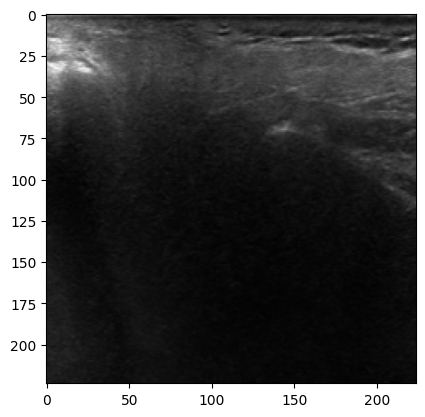

In [14]:
sample_img = transforms.functional.to_pil_image(img[0])
plt.imshow(sample_img)

In [15]:
import timm

class CustomModel(nn.Module):
    if CFG['MODEL'] == 1:
        def __init__(self, classes=2):
            super().__init__()
            self.model = timm.create_model("resnet50", pretrained=True)
            self.model.fc = nn.Linear(in_features=2048, out_features=classes, bias=True)
            self.softmax = nn.Softmax(dim=-1)

        def forward(self, x):
            x = self.model(x)
            x = self.softmax(x)
            
            return x

    elif CFG['MODEL'] == 2:
        def __init__(self, classes=2):
            super().__init__()
            self.model = timm.create_model("vgg16_bn", pretrained=True)
            self.model.head.fc = nn.Linear(in_features=4096, out_features=classes, bias=True)
            self.softmax = nn.Softmax(dim=-1)

        def forward(self, x):
            x = self.model(x)
            x = self.softmax(x)
            
            return x
    
    elif CFG['MODEL'] == 3:
        def __init__(self, classes=2):
            super().__init__()
            self.model = timm.create_model("inception_v3", pretrained=True)
            self.model.fc = nn.Linear(in_features=2048, out_features=classes, bias=True)
            self.softmax = nn.Softmax(dim=-1)

        def forward(self, x):
            x = self.model(x)
            x = self.softmax(x)

            return x

c:\Users\PC00\anaconda3\envs\torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
model = CustomModel().to(device)
# model = nn.DataParallel(model)

In [17]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=CFG['LR'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.8)

# TRAIN DATASET

In [18]:
def train_loop(dataloader, model, optimizer, loss_fn, scheduler, model_save_path):
    # model.load_state_dict(torch.load(model_save_path))
    model.train()

    size = len(dataloader)
    datasize = len(dataloader.dataset)

    best_loss = 100
    loss_hist=[]
    acc_hist=[]

    for epoch in range(CFG['EPOCHS']):
        epoch_start = time.time()

        loss_item=0
        correct=0
        print(f"Start epoch : {epoch+1}")
        for batch, (X, y) in enumerate(dataloader):
            X = X.to(device).float()
            y = y.to(device).float()

            output = model(X)

            loss = loss_fn(output, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_item += loss.item()

            correct+=(output.argmax(1)==y.argmax(1)).detach().cpu().sum().item()

            if batch % 50 == 0:
                print(f"Batch loss : {(loss):>.5f} {batch}/{size}")

        curr_loss = loss_item/size
        curr_acc = correct/datasize
        loss_hist.append(curr_loss)
        acc_hist.append(curr_acc*100)

        if curr_loss < best_loss:
            best_loss = curr_loss
            best_loss_model = deepcopy(model.state_dict())

        print(f"Loss : {(curr_loss):>.5f} ACC : {(curr_acc*100):>.2f}%")

        epoch_end = time.time()
        scheduler.step()
        print(f"End epoch : {epoch+1}")
        print(f"Epoch time : {(epoch_end-epoch_start)//60} min {(epoch_end-epoch_start)%60} sec")
        print()

    torch.save(best_loss_model, model_save_path)

    return loss_hist, acc_hist

In [19]:
loss_hist, acc_hist = train_loop(train_dataloader, model, optimizer, loss_fn, scheduler, model_save_path)

Start epoch : 1
Batch loss : 0.69611 0/190
Batch loss : 0.54817 50/190
Batch loss : 0.49983 100/190
Batch loss : 0.46640 150/190
Loss : 0.47917 ACC : 82.90%
End epoch : 1
Epoch time : 1.0 min 37.67689561843872 sec

Start epoch : 2
Batch loss : 0.38674 0/190
Batch loss : 0.40131 50/190
Batch loss : 0.41426 100/190
Batch loss : 0.40903 150/190
Loss : 0.38089 ACC : 92.98%
End epoch : 2
Epoch time : 1.0 min 27.700782299041748 sec

Start epoch : 3
Batch loss : 0.35814 0/190
Batch loss : 0.36597 50/190
Batch loss : 0.33768 100/190
Batch loss : 0.37541 150/190
Loss : 0.35313 ACC : 96.03%
End epoch : 3
Epoch time : 1.0 min 27.843294620513916 sec

Start epoch : 4
Batch loss : 0.37884 0/190
Batch loss : 0.32499 50/190
Batch loss : 0.33115 100/190
Batch loss : 0.31887 150/190
Loss : 0.34336 ACC : 96.98%
End epoch : 4
Epoch time : 1.0 min 28.187082529067993 sec

Start epoch : 5
Batch loss : 0.35236 0/190
Batch loss : 0.32928 50/190
Batch loss : 0.32264 100/190
Batch loss : 0.31401 150/190
Loss : 0

Text(0.5, 1.0, 'Train Loss')

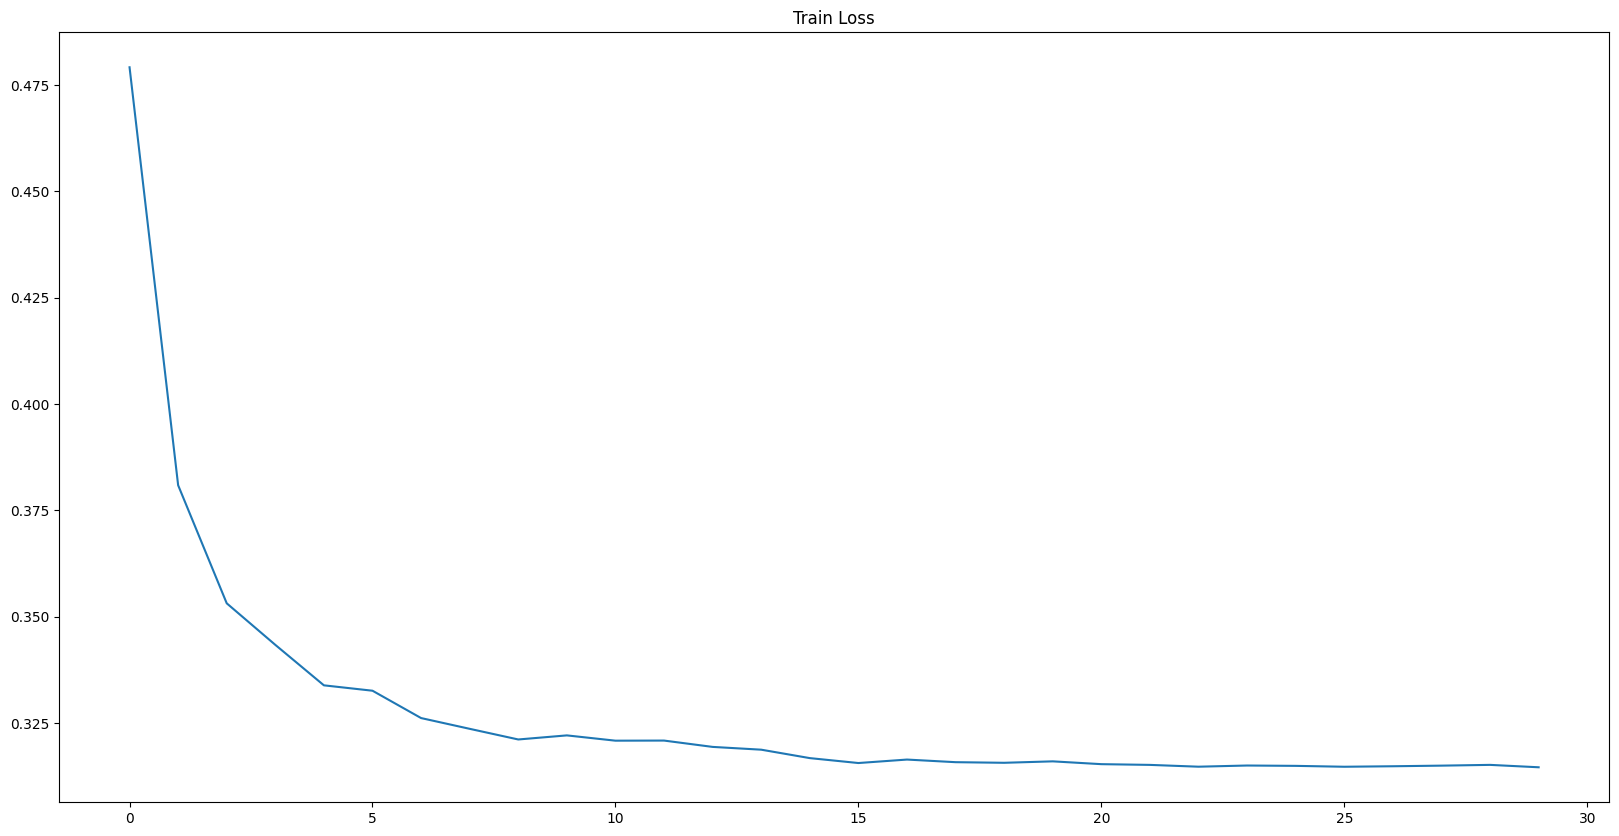

In [20]:
plt.figure(figsize=(20,10))
plt.plot(loss_hist)
plt.title('Train Loss')

Text(0.5, 1.0, 'Train Accuracy')

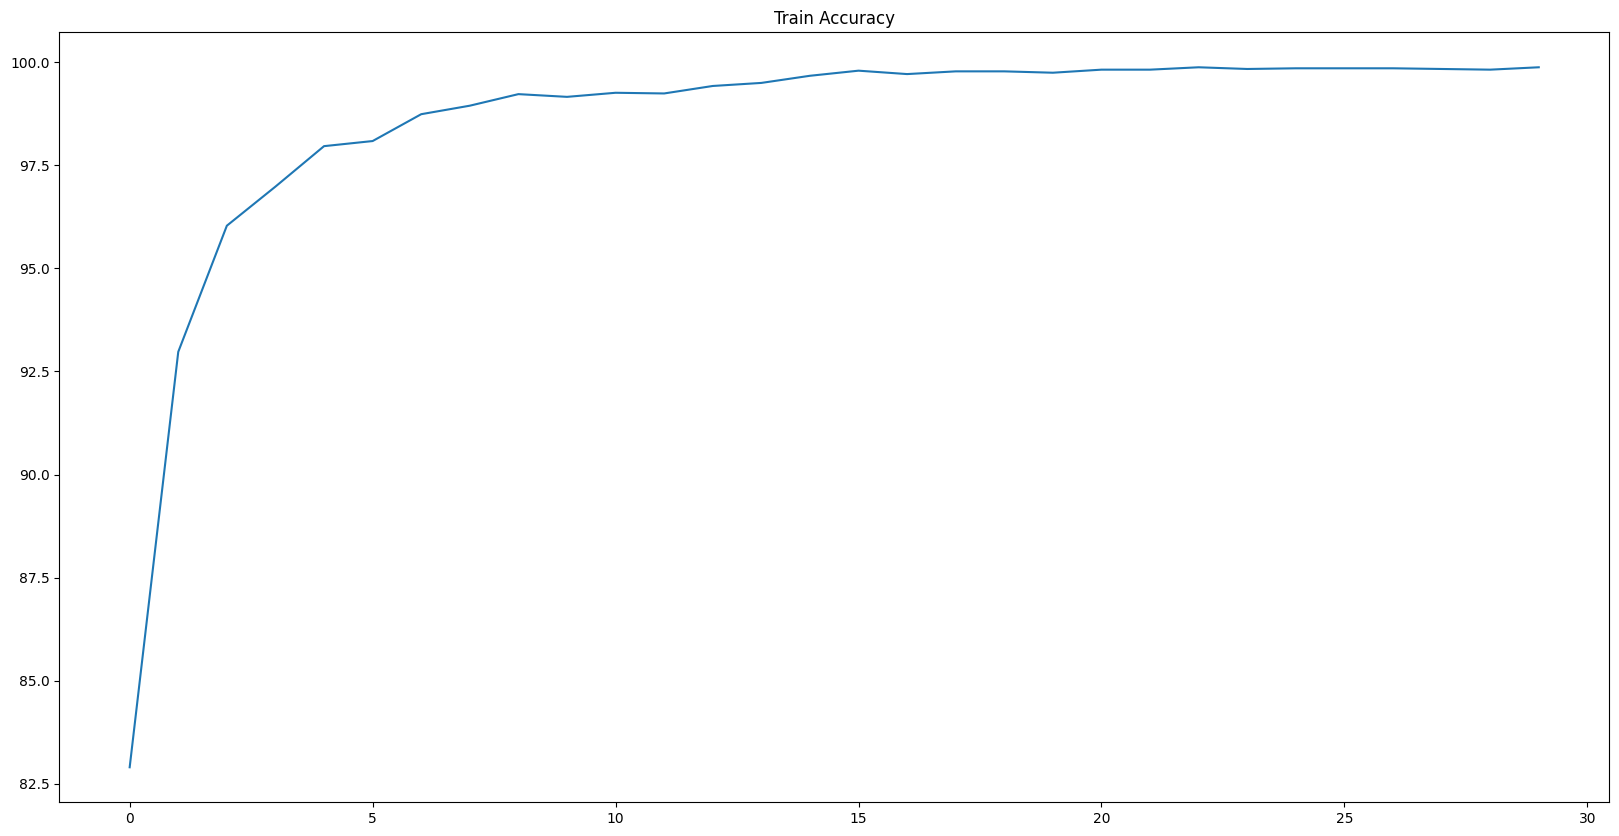

In [21]:
plt.figure(figsize=(20,10))
plt.plot(acc_hist)
plt.title('Train Accuracy')